In this notebook we consider a simple 1d global optimization task powered by the Tensor Train (TT).
Technically here we perform a search over 2^40 points.

First, one needs to define an encoder, that maps bit strings (indices of a TT) into values in the
interval (0, 2) where we are going to search for a maximum modulo value of a function.

In [1]:
import numpy as np
from ttrs import TTVc64

# It is a number of TT modes (indices)
MODES_NUM = 40

# this is the encoder function, it converts a bit-string (index of a TT) into a value
# from the interval (0, 2)
def encoder(index):
    if index is None:
        return None
    else:
        weights = 1 / (2 ** np.arange(0, MODES_NUM))
        return np.array(np.tensordot(index, weights, axes=1), dtype=np.complex128)

Now let us choose a function, that is inconvenient for optimization.
In the cell below, we defined and plotted this function.
The maximum modulo is achieved for x = 1.23456789, but this value corresponds
to a very high peak that usually is difficult to detect.

Text(0.5, 0, 'x')

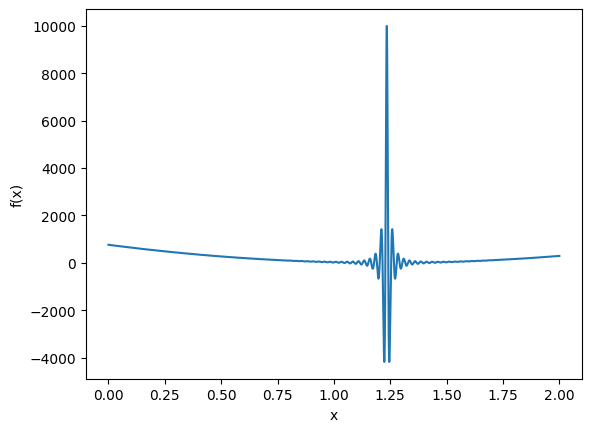

In [2]:
import matplotlib.pyplot as plt

# now let us define a function that we will be studying
def weird_function(x):
    return np.cos(250 * (x - 1.23456789)) / ((x - 1.23456789) ** 2 + 0.0001) + 500 * (x - 1.23456789) ** 2

x = np.linspace(0, 2, 100000)

plt.plot(x, weird_function(x))
plt.ylabel("f(x)")
plt.xlabel("x")


Let us reconstruct the TT representation of this function. For this purpose we run TTCross
with the following parameters: maxrank = 30, number of DMRG sweep = 6. After this, we set the corresponding TT into
the left-canonical form and truncate it with accuracy 1e-9. We also track additional data during TTCross run in order to use them later for optimization.

In [6]:
tt_weird_function = TTVc64(
    MODES_NUM * [2], # modes dimensions of a tensor train
    20,              # max TT rank
    1e-5,            # accuracy of the maxvol algorithm
    True             # flag showing if we need to track data for TTOpt method (https://arxiv.org/abs/2205.00293)
)

for _ in range(MODES_NUM * 6):
    index = tt_weird_function.get_args()
    if index is None:
        tt_weird_function.update(None)
    else:
        val = weird_function(encoder(index))
        tt_weird_function.update(val)

tt_weird_function.set_into_left_canonical()
tt_weird_function.truncate_left_canonical(1e-10)
print("Bond dimensions:", tt_weird_function.get_bonds())

Bond dimensions: [2, 4, 8, 14, 15, 13, 12, 11, 10, 8, 7, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


To find a maximum modulo element we use two methods. First one combines optimization methods from https://arxiv.org/abs/2101.03377 and https://arxiv.org/abs/2209.14808. Second one is called TTOpt and it is approximate method from https://arxiv.org/abs/2205.00293.

In [13]:
argmax = tt_weird_function.argmax_modulo(
    1e-10, # truncation accuracy
    1000, # max number of power iterations
    20,   # max tt-rank during the power iteration
    10,   # hyperparameter K from the paper https://arxiv.org/abs/2209.14808
)
tt_opt_argmax = tt_weird_function.tt_opt_argmax_module()
print("Argmax bitsring", argmax)
print("TTOpt argmax bitsring", tt_opt_argmax)

Argmax bitsring [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TTOpt argmax bitsring [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]


Now let as convert the found argmax index of a tensor train into the corresponding argmax argument of a function,
using the encoder function and plot the optimization results.

Found argmax:  1.2345678806304932
Found tt_opt argmax:  1.2345678805613716
Genuine argmax:  1.23456789
Found maximum:  9999.999999963786
Found tt_opt maximum:  9999.99999996325
Genuine maximum:  10000


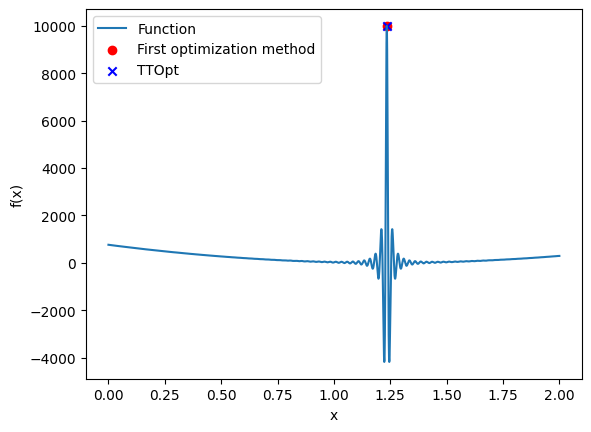

In [14]:
argmax = encoder(argmax)
tt_opt_argmax = encoder(tt_opt_argmax)

# this is the corresponding max value
max = weird_function(argmax)

tt_opt_max = weird_function(tt_opt_argmax)

# And here we print the result, and plot the max point in red

print("Found argmax: ", argmax.real)
print("Found tt_opt argmax: ", tt_opt_argmax.real)
print("Genuine argmax: ", 1.23456789)
print("Found maximum: ", weird_function(argmax.real))
print("Found tt_opt maximum: ", weird_function(tt_opt_argmax.real))
print("Genuine maximum: ", 10000)

x = np.linspace(0, 2, 100000)
plt.plot(x, weird_function(x))
plt.ylabel("f(x)")
plt.xlabel("x")
plt.scatter(argmax, max, color='r')
plt.scatter(tt_opt_argmax, max, color='b', marker='x')
plt.legend(["Function", "First optimization method", "TTOpt"])